# PROCESO DE LIMPIEZA Y PRESENTACIÓN DE LOS DATOS

## Datos de Polución del Aire (SINCA)

La base de datos utilizada proviene del Sistema de Información Nacional de Calidad del Aire (SINCA) del Ministerio del Medio Ambiente de Chile, y contiene registros horarios de material particulado fino (PM₂.₅) de distintas estaciones ubicadas en la Región Metropolitana de Santiago. Se incluyen registros para el período 2017–2019, provenientes de diez comunas: Cerro Navia, Pudahuel, Quilicura, El Bosque, Cerrillos, Independencia, Las Condes, La Florida, Puente Alto y Parque O’Higgins. (https://sinca.mma.gob.cl/index.php/region/index/id/M)

Cada archivo .csv corresponde por cada estación de monitoreo de calidad del aire según su comuna desde el 2017 al 2019 en las comunas ya mencionadas. Contienen columnas como:

FECHA (YYMMDD) → fecha del registro en formato numérico (ej. 170101 para 1 de enero de 2017)

HORA (HHMM) → hora del registro

Registros validados → mediciones de PM₂.₅ validadas

Registros preliminares → mediciones de PM₂.₅ aún sin validar

Registros no validados → mediciones descartadas o sin revisión

Unnamed: 5 → columna vacía generada por el CSV

Los archivos fueron combinados en un solo DataFrame llamado df_contaminacion, agregando una columna estacion que indica la comuna de origen, y se generó una columna unificada PM25 que prioriza los registros validados y, cuando estos no existen, utiliza los preliminares. La decisión de unificar los registros validados y preliminares en PM25 permite aprovechar todos los datos disponibles sin perder calidad.

In [147]:
import pandas as pd
import os
import datetime as dt
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
from bs4 import BeautifulSoup

Lectura de datos del SINCA

In [148]:
ruta_sinca = os.path.join('data', 'Estaciones17-19')

# Diccionario de DataFrames
dfs_sinca = {}

for f in os.listdir(ruta_sinca):
    if f.endswith(".csv"):
        nombre = f.replace(".csv", "")  
        df = pd.read_csv(os.path.join(ruta_sinca, f), sep=';', decimal=',')
        dfs_sinca[nombre] = df

# Ejemplo de acceso
# dfs_sinca.keys()

# creamos columna con el nombre de cada estación
for nombre, df in dfs_sinca.items():
    df["Estacion"] = nombre.split("17-19")[0]
# dfs_sinca["Cerronavia17-19"].head()

# concatenar todos los DataFrames en uno solo ahora que ya sabemos a qué comuna corresponde cada medición
df_contaminacion = pd.concat(dfs_sinca.values(), ignore_index=True)
df_contaminacion.head()

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados,Unnamed: 5,Estacion
0,170101,0,19.9167,NaN,NaN,NaN,Cerronavia
1,170102,0,25.0833,NaN,NaN,NaN,Cerronavia
2,170103,0,42.5000,NaN,NaN,NaN,Cerronavia
3,170104,0,21.1250,NaN,NaN,NaN,Cerronavia
4,170105,0,17.7083,NaN,NaN,NaN,Cerronavia


Sabemos que "Parque O'Higgins" es parte de la comuna de Santiago.

In [149]:
df_contaminacion['Estacion'].unique()

array(['Cerronavia', 'Elbosque', 'Independencia', 'Laflorida',
       'Lascondes', 'ParqueOHiggins', 'Pudahuel', 'Puentealto',
       'Quilicura', 'Talagante'], dtype=object)

In [150]:
# cambiar los nombres de las estaciones a nombres más amigables
nombre_estaciones = {
    'Cerronavia':'Cerro Navia', 'Elbosque': 'El Bosque', 'Independencia': 'Independencia', 'Laflorida':'La Florida',
    'Lascondes':'Las Condes', 'ParqueOHiggins':'Santiago', 'Pudahuel':'Pudahuel', 'Puentealto':'Puente Alto',
    'Quilicura':'Quilicura', 'Talagante':'Talagante'}

df_contaminacion['Estacion'] = df_contaminacion['Estacion'].map(nombre_estaciones)

# renombrar columna FECHA (YYMMDD) a FECHA y HORA (HHMM) a HORA
df_contaminacion = df_contaminacion.rename(columns={"FECHA (YYMMDD)": "FECHA", "HORA (HHMM)": "HORA"})

#Tranformamos fechas a datetime
df_contaminacion["FECHA"] = pd.to_datetime(df_contaminacion["FECHA"], format="%y%m%d", errors="coerce")

#Creamos una columna llamada PM25 con los valores de PM25 reemplazando aquellos registros que no tienen registros validados por registros preliminares
df_contaminacion["PM25"] = df_contaminacion["Registros validados"].fillna(df_contaminacion["Registros preliminares"])

# Eliminamo la columna Registros no validados y Unnamed: 5
df_contaminacion = df_contaminacion.drop(columns=["Registros no validados", "Unnamed: 5"], errors="ignore")

## Reportes de Salud MINSAL
- link: [Reportes Rem](https://reportesrem.minsal.cl/)

Los archivos a leer son con extensión `xls` con formato `html` escondido. La secuencia para solicitar los archivos y descargarlos de su fuente original es la siguiente:

#### Parámetros de los filtros:
- Serie -> **SERIE A**
- Rem -> **REMA04. CONSULTAS Y OTRAS ATENCIONES**
- Sección -> **SECCIÓN A: CONSULTAS MÉDICAS**
- Degregación -> **REGIONES**
- Regiones -> **METROPOLITANA DE SANTIAGO**
- Periodo -> **{año}**
- Mes Inicio -> **{mes}**
- Mes Final -> **{mes}**

En este caso se descargaron mes a mes.

In [151]:
rutaREMZip17 = os.path.join('data', 'REM', 'REM_2017.zip')
rutaREMZip18 = os.path.join('data', 'REM', 'REM_2018.zip')
rutaREMZip19 = os.path.join('data', 'REM', 'REM_2019.zip')

archivoREMZip2017 = zipfile.ZipFile(rutaREMZip17, 'r')
archivoREMZip2018 = zipfile.ZipFile(rutaREMZip18, 'r')
archivoREMZip2019 = zipfile.ZipFile(rutaREMZip19, 'r')

with archivoREMZip2017 as ar_REM_zip2017:
    ar_REM_zip2017.extractall(path='data/REM/')

with archivoREMZip2018 as ar_REM_zip2018:
    ar_REM_zip2018.extractall(path='data/REM/')

with archivoREMZip2019 as ar_REM_zip2019:
    ar_REM_zip2019.extractall(path='data/REM/')


# con esta función se extraen los datos de los archivos html escondidos en los xls y los retorna en formato DataFrame
def tranformar_html(mes_archivo, anio_archivo, nombre_archivo, carpeta_archivo='data'):
    ruta = os.path.join(carpeta_archivo, 'REM','REM_' + str(anio_archivo), nombre_archivo)
    html_text = open(ruta,'r', encoding='utf-8').read()
    soup = BeautifulSoup(html_text, "html.parser")

    tables = soup.find_all('table')
    body = soup.find('tbody')

    datos = []
    comuna_actual = None
    filas = body.find_all('tr')
    for fila in filas:
        texto_fila = fila.get_text(strip=True).upper()
        
        
        if 'COMUNA:' in texto_fila:
            comuna_actual = texto_fila.split('COMUNA:')[-1].strip().title()
            continue

        if 'ESTABLECIMIENTO:' in texto_fila:
            comuna_actual = None
            continue

        if comuna_actual:
            celdas = fila.find_all('td')
            if len(celdas) >= 2:
                consulta = celdas[0].get_text(strip=True)
                valor = celdas[1].get_text(strip=True)
                if consulta and valor and consulta.upper() != 'TOTAL':
                    datos.append([consulta, valor, comuna_actual, mes_archivo, anio_archivo])
    

    df = pd.DataFrame(datos, columns = ['Consulta_por', 'n_pacientes','Comuna', 'Mes', 'Año'])
    print(f"Datos procesados para {mes_archivo} {anio_archivo}.")

    # conseva solo las columnas que corresponden a areas de enfermedades respiratorias
    df = df[(df['Consulta_por'] != 'OBSTETRICA') & (df['Consulta_por'] != 'GINECOLOGICA') & (df['Consulta_por'] != 'GINECOLOGICA  POR INFERTILIDAD') & (df['Consulta_por'] != 'INFECCIÓN TRANSMISIÓN SEXUAL') & (df['Consulta_por'] != 'VIH-SIDA') & (df['Consulta_por'] != 'SALUD MENTAL') & (df['Consulta_por'] != 'OTRAS MORBILIDADES')]

    return df

Cargamos los datos REM de 2017

In [152]:
# cargamos los datos de 2017
df_REM_enero_2017 = tranformar_html('enero',2017,'REM_enero_2017.xls')
df_REM_febrero_2017 = tranformar_html('febrero',2017,'REM_febrero_2017.xls')
df_REM_marzo_2017 = tranformar_html('marzo',2017,'REM_marzo_2017.xls')
df_REM_abril_2017 = tranformar_html('abril',2017,'REM_abril_2017.xls')
df_REM_mayo_2017 = tranformar_html('mayo',2017,'REM_mayo_2017.xls')
df_REM_junio_2017 = tranformar_html('junio',2017,'REM_junio_2017.xls')
df_REM_julio_2017 = tranformar_html('julio',2017,'REM_julio_2017.xls')
df_REM_agosto_2017 = tranformar_html('agosto',2017,'REM_agosto_2017.xls')
df_REM_septiembre_2017 = tranformar_html('septiembre',2017,'REM_septiembre_2017.xls')
df_REM_octubre_2017 = tranformar_html('octubre',2017,'REM_octubre_2017.xls')
df_REM_noviembre_2017 = tranformar_html('noviembre',2017,'REM_noviembre_2017.xls')
df_REM_diciembre_2017 = tranformar_html('diciembre',2017,'REM_diciembre_2017.xls')

Datos procesados para enero 2017.
Datos procesados para febrero 2017.
Datos procesados para marzo 2017.
Datos procesados para abril 2017.
Datos procesados para mayo 2017.
Datos procesados para junio 2017.
Datos procesados para julio 2017.
Datos procesados para agosto 2017.
Datos procesados para septiembre 2017.
Datos procesados para octubre 2017.
Datos procesados para noviembre 2017.
Datos procesados para diciembre 2017.


Cargamos los datos REM de 2018

In [153]:
df_REM_enero_2018 = tranformar_html('enero',2018,'REM_enero_2018.xls')
df_REM_febrero_2018 = tranformar_html('febrero',2018,'REM_febrero_2018.xls')
df_REM_marzo_2018 = tranformar_html('marzo',2018,'REM_marzo_2018.xls')
df_REM_abril_2018 = tranformar_html('abril',2018,'REM_abril_2018.xls')
df_REM_mayo_2018 = tranformar_html('mayo',2018,'REM_mayo_2018.xls')
df_REM_junio_2018 = tranformar_html('junio',2018,'REM_junio_2018.xls')
df_REM_julio_2018 = tranformar_html('julio',2018,'REM_julio_2018.xls')
df_REM_agosto_2018 = tranformar_html('agosto',2018,'REM_agosto_2018.xls')
df_REM_septiembre_2018 = tranformar_html('septiembre',2018,'REM_septiembre_2018.xls')
df_REM_octubre_2018 = tranformar_html('octubre',2018,'REM_octubre_2018.xls')
df_REM_noviembre_2018 = tranformar_html('noviembre',2018,'REM_noviembre_2018.xls')
df_REM_diciembre_2018 = tranformar_html('diciembre',2018,'REM_diciembre_2018.xls')

Datos procesados para enero 2018.
Datos procesados para febrero 2018.
Datos procesados para marzo 2018.
Datos procesados para abril 2018.
Datos procesados para mayo 2018.
Datos procesados para junio 2018.
Datos procesados para julio 2018.
Datos procesados para agosto 2018.
Datos procesados para septiembre 2018.
Datos procesados para octubre 2018.
Datos procesados para noviembre 2018.
Datos procesados para diciembre 2018.


Cargamos los datos REM de 2019

In [154]:
df_REM_enero_2019 = tranformar_html('enero',2019,'REM_enero_2019.xls')
df_REM_febrero_2019 = tranformar_html('febrero',2019,'REM_febrero_2019.xls')
df_REM_marzo_2019 = tranformar_html('marzo',2019,'REM_marzo_2019.xls')
df_REM_abril_2019 = tranformar_html('abril',2019,'REM_abril_2019.xls')
df_REM_mayo_2019 = tranformar_html('mayo',2019,'REM_mayo_2019.xls')
df_REM_junio_2019 = tranformar_html('junio',2019,'REM_junio_2019.xls')
df_REM_julio_2019 = tranformar_html('julio',2019,'REM_julio_2019.xls')
df_REM_agosto_2019 = tranformar_html('agosto',2019,'REM_agosto_2019.xls')
df_REM_septiembre_2019 = tranformar_html('septiembre',2019,'REM_septiembre_2019.xls')
df_REM_octubre_2019 = tranformar_html('octubre',2019,'REM_octubre_2019.xls')
df_REM_noviembre_2019 = tranformar_html('noviembre',2019,'REM_noviembre_2019.xls')
df_REM_diciembre_2019 = tranformar_html('diciembre',2019,'REM_diciembre_2019.xls')

Datos procesados para enero 2019.
Datos procesados para febrero 2019.
Datos procesados para marzo 2019.
Datos procesados para abril 2019.
Datos procesados para mayo 2019.
Datos procesados para junio 2019.
Datos procesados para julio 2019.
Datos procesados para agosto 2019.
Datos procesados para septiembre 2019.
Datos procesados para octubre 2019.
Datos procesados para noviembre 2019.
Datos procesados para diciembre 2019.


Creamos un dataframe por cada año:

In [155]:
df_REM_2017 = pd.concat([df_REM_enero_2017, df_REM_febrero_2017, df_REM_marzo_2017, df_REM_abril_2017, df_REM_mayo_2017, df_REM_junio_2017, 
                        df_REM_julio_2017, df_REM_agosto_2017,df_REM_septiembre_2017, df_REM_octubre_2017, df_REM_noviembre_2017, df_REM_diciembre_2017])

In [156]:
df_REM_2018 = pd.concat([df_REM_enero_2018, df_REM_febrero_2018, df_REM_marzo_2018, df_REM_abril_2018, df_REM_mayo_2018, df_REM_junio_2018, 
                        df_REM_julio_2018, df_REM_agosto_2018,df_REM_septiembre_2018, df_REM_octubre_2018, df_REM_noviembre_2018, df_REM_diciembre_2018])

In [157]:
df_REM_2019 = pd.concat([df_REM_enero_2019, df_REM_febrero_2019, df_REM_marzo_2019, df_REM_abril_2019, df_REM_mayo_2019, df_REM_junio_2019, 
                        df_REM_julio_2019, df_REM_agosto_2019,df_REM_septiembre_2019, df_REM_octubre_2019, df_REM_noviembre_2019, df_REM_diciembre_2019])

In [216]:
# guardar los dataframes en archivos rapidos de leer, como .csv
df_REM_2017.to_csv(os.path.join('data', 'REM', 'df_REM_2017.csv'), index=False)
df_REM_2018.to_csv(os.path.join('data', 'REM', 'df_REM_2018.csv'), index=False)
df_REM_2019.to_csv(os.path.join('data', 'REM', 'df_REM_2019.csv'), index=False)

Limpieza de los datos de REM:

In [158]:
# LIMPIAMOS LA COLUMNA n_pacientes CONVIERTIENDOLA A TIPO INT64
df_REM17 = df_REM_2017.copy()
df_REM17['n_pacientes'] = df_REM17['n_pacientes'].str.replace('.','')
df_REM17['n_pacientes'] = df_REM17['n_pacientes'].astype('int64')

df_REM18 = df_REM_2018.copy()
df_REM18['n_pacientes'] = df_REM18['n_pacientes'].str.replace('.','')
df_REM18['n_pacientes'] = df_REM18['n_pacientes'].astype('int64')

df_REM19 = df_REM_2019.copy()
df_REM19['n_pacientes'] = df_REM19['n_pacientes'].str.replace('.','')
df_REM19['n_pacientes'] = df_REM19['n_pacientes'].astype('int64')

# ESTANDARIZAMOS LOS MESES
df_REM17['Mes'] = df_REM17['Mes'].str.capitalize()
df_REM18['Mes'] = df_REM18['Mes'].str.capitalize()
df_REM19['Mes'] = df_REM19['Mes'].str.capitalize()

# CREAMOS COLUMNA NUM_MES (FACILITA AL MOMENTO DE GRAFICAR)
mapeo_meses = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4,
    'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8,
    'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}

df_REM17['Num_mes'] = df_REM17['Mes'].map(mapeo_meses)
df_REM18['Num_mes'] = df_REM18['Mes'].map(mapeo_meses)
df_REM19['Num_mes'] = df_REM19['Mes'].map(mapeo_meses)

Veremos si se limpiaron bien las los tipos de consulta en los dataframes:

In [159]:
df_REM17['Consulta_por'].unique()

array(['IRA ALTA', 'SINDROME BRONQUIAL OBSTRUCTIVO', 'NEUMONÍA', 'ASMA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA', 'OTRAS RESPIRATORIAS'],
      dtype=object)

In [160]:
df_REM18['Consulta_por'].unique()

array(['IRA ALTA', 'SINDROME BRONQUIAL OBSTRUCTIVO', 'NEUMONÍA', 'ASMA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA', 'OTRAS RESPIRATORIAS',
       'CARDIOVASCULAR'], dtype=object)

In [161]:
df_REM19['Consulta_por'].unique()

array(['IRA ALTA', 'SINDROME BRONQUIAL OBSTRUCTIVO', 'NEUMONÍA', 'ASMA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA', 'OTRAS RESPIRATORIAS',
       'CARDIOVASCULAR'], dtype=object)

Observamos que la consulta de tipo "CARDIOVASCULAR" no corresponde a una enfermedad respiratoria, por lo cual no corresponde que esté presente en el análisis. Lo eliminamos.

In [ ]:
df_REM18 = df_REM18[df_REM18['Consulta_por'] != 'CARDIOVASCULAR']
df_REM19 = df_REM19[df_REM19['Consulta_por'] != 'CARDIOVASCULAR']

In [163]:
df_REM18['Consulta_por'].unique()

array(['IRA ALTA', 'SINDROME BRONQUIAL OBSTRUCTIVO', 'NEUMONÍA', 'ASMA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA', 'OTRAS RESPIRATORIAS'],
      dtype=object)

In [164]:
df_REM19['Consulta_por'].unique()

array(['IRA ALTA', 'SINDROME BRONQUIAL OBSTRUCTIVO', 'NEUMONÍA', 'ASMA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA', 'OTRAS RESPIRATORIAS'],
      dtype=object)

In [165]:
df_REM17['Consulta_por'] = df_REM17['Consulta_por'].astype('category')
df_REM18['Consulta_por'] = df_REM18['Consulta_por'].astype('category')
df_REM19['Consulta_por'] = df_REM19['Consulta_por'].astype('category')

Notar que el df, no tiene filas nulas.

In [166]:
df_REM17[df_REM17.isna().all(axis=1)]

,Consulta_por,n_pacientes,Comuna,Mes,Año,Num_mes


El data frame, tampoco tiene datos duplicados.

In [167]:
dups2017 = df_REM17.duplicated(keep=False)
dups2017 = df_REM17[dups2017]

dups2017

,Consulta_por,n_pacientes,Comuna,Mes,Año,Num_mes


## Mapa de la Región Metropolitana

Mapa vectorizado de todas las comunas de chile:

https://www.bcn.cl/siit/mapas_vectoriales

C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\4222327275.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


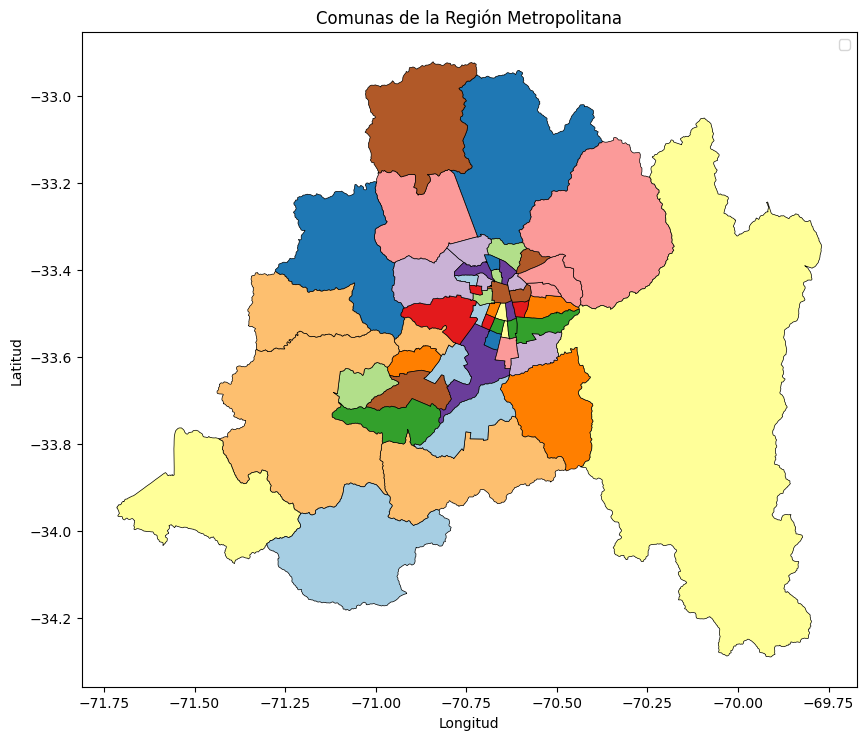

In [168]:
zipComunas = zipfile.ZipFile('data/Comunas/Comunas.zip', 'r')
with zipComunas as zip_coms:
    zip_coms.extractall(path='data/Comunas/')

# Para no tener problemas con computadores mac usamos join

nombre_archivo = 'comunas.shp'
ruta = os.path.join('data', 'Comunas', nombre_archivo)
comunas = gpd.read_file(ruta, use_arrow=True)

# reseteamos el crs a 4326
comunas['geometry'] = comunas['geometry'].to_crs(epsg=4326)

# dejamos solo las comunas de la RM
comunas = comunas[comunas['Region'] == 'Región Metropolitana de Santiago'].copy().reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 10))
comunas.plot(column='Comuna', ax=ax, cmap='Paired', legend=True, linewidth=0.5, edgecolor='black')

ax.set_title("Comunas de la Región Metropolitana")
# titulo de los ejes
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.legend()
plt.show()

Vemos que éstas son las comunas que presentan medidores de contaminación aerea:

C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\2939393531.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\2939393531.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


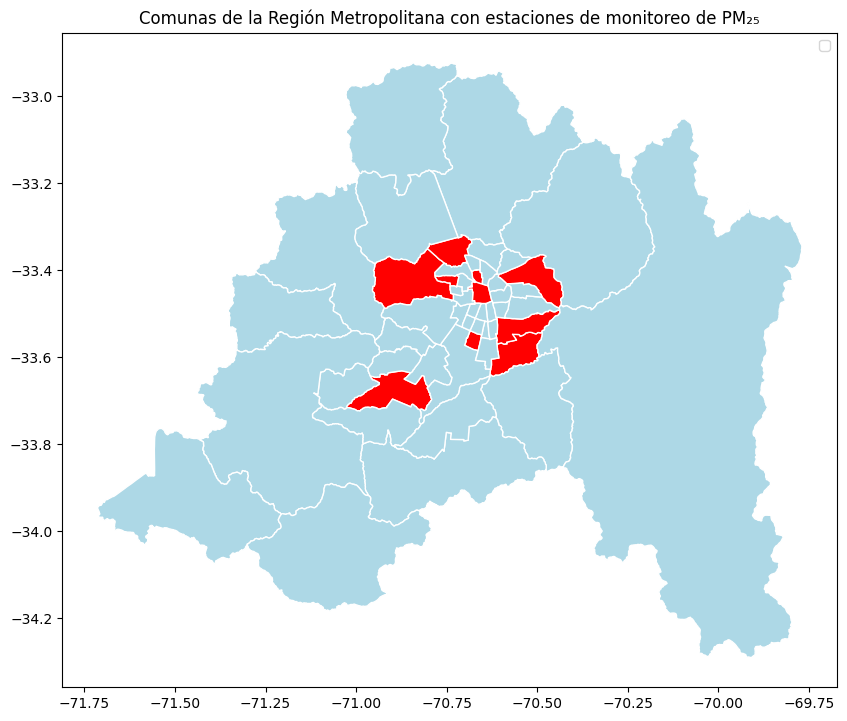

In [169]:
# Mostramos todas las comunas, distinguimos las que tienen estaciones de monitoreo de PM25 con rojo de las que no con celeste
medidores = list(df_contaminacion['Estacion'].unique())

fig, ax = plt.subplots(figsize=(10, 10))
comunas['Tiene_medidor'] = comunas['Comuna'].map(lambda x: x in medidores)

dentro = comunas[comunas['Tiene_medidor'] == True]
fuera_lista = comunas[comunas['Tiene_medidor'] == False]

dentro.plot(ax=ax, color='red', label='Con medidores', edgecolor='white')
fuera_lista.plot(ax=ax, color='lightblue', label='Sin medidores', edgecolor='white')

ax.set_title("Comunas de la Región Metropolitana con estaciones de monitoreo de PM₂₅")
ax.legend()
plt.show()

# ANALISIS NUMÉRICO

## Analisis numérico de comunas con (df_contaminacion)

In [170]:
df_contaminacion.head()

,FECHA,HORA,Registros validados,Registros preliminares,Estacion,PM25
0,2017-01-01,0,19.9167,NaN,Cerro Navia,19.9167
1,2017-01-02,0,25.0833,NaN,Cerro Navia,25.0833
2,2017-01-03,0,42.5000,NaN,Cerro Navia,42.5000
3,2017-01-04,0,21.1250,NaN,Cerro Navia,21.1250
4,2017-01-05,0,17.7083,NaN,Cerro Navia,17.7083


In [171]:
# Conteo total de nulos (sin registros validados ni preliminares)
nulos_total = df_contaminacion["PM25"].isna().sum()
total_registros = len(df_contaminacion)
porcentaje_nulos = (nulos_total / total_registros) * 100

print(f"Total de registros: {total_registros}")
print(f"Valores nulos en PM25: {nulos_total} ({porcentaje_nulos:.2f}%)")

Total de registros: 10940
Valores nulos en PM25: 582 (5.32%)


In [172]:
nulos_por_estacion = (
    df_contaminacion.groupby("Estacion")["PM25"]
    .apply(lambda x: x.isna().sum())
    .reset_index(name="nulos")
)

# Agregar porcentaje por estación
nulos_por_estacion["porcentaje"] = (
    nulos_por_estacion["nulos"] /
    df_contaminacion["Estacion"].value_counts().sort_index().values
) * 100

print(nulos_por_estacion)

        Estacion  nulos  porcentaje
0    Cerro Navia     45    4.113346
1      El Bosque     55    5.027422
2  Independencia     42    3.839122
3     La Florida     75    6.855576
4     Las Condes     56    5.118830
5       Pudahuel     52    4.753199
6    Puente Alto     47    4.296161
7      Quilicura     68    6.215722
8       Santiago     38    3.473492
9      Talagante    104    9.506399


Del total de 10.940 registros disponibles, se identificaron 582 valores faltantes en la variable PM₂.₅, equivalente al 5.32 % del conjunto de datos.
Estos casos corresponden a horas en las cuales las estaciones no registraron valores ni validados ni preliminares, posiblemente por mantenimiento o fallas técnicas.
Dado que la proporción de datos faltantes es moderada, se optó por eliminarlos del análisis.

In [173]:
df_contaminacion = df_contaminacion.dropna(subset=["PM25"])

In [174]:
# Promedio mensual (para graficar tendencias)
df_contaminacion.groupby([df_contaminacion["FECHA"].dt.month, "Estacion"])["PM25"].mean().unstack()

Estacion,Cerro Navia,El Bosque,Independencia,La Florida,Las Condes,Pudahuel,Puente Alto,Quilicura,Santiago,Talagante
FECHA,,,,,,,,,,
1,21.566306,23.411162,25.377509,22.292601,24.040539,19.747309,20.462530,22.002691,22.914684,15.113699
2,17.850607,20.287103,19.854935,16.839518,18.422698,16.614130,15.355764,16.843877,18.481648,11.639735
3,18.270054,20.264554,17.764832,17.236677,17.852412,16.465019,15.682777,16.906531,18.873933,12.610276
4,28.759261,29.800150,25.761008,26.450460,22.919354,25.656631,23.126287,24.160606,24.876813,19.269707
5,43.387097,41.741935,33.795699,33.641304,24.434783,39.704545,27.827957,33.560440,33.731183,32.159091
6,59.625000,54.244444,42.977528,40.855556,24.306818,54.920455,32.988764,44.494253,44.200000,42.308642
7,58.086022,55.413043,46.163043,43.865169,29.134831,53.380435,36.988889,44.892473,46.086022,43.634409
8,41.387097,41.184783,35.195652,34.380435,25.247312,37.163043,29.173913,33.630435,35.021505,30.086022
9,25.879518,25.775000,23.975904,23.468354,19.615385,23.294872,20.101124,21.518519,23.392857,17.975309


In [175]:
# Conteo de datos por año
df_contaminacion["FECHA"].dt.year.value_counts()

FECHA
2019    3500
2017    3440
2018    3418
Name: count, dtype: int64

#### Estadísticas descriptivas

El análisis inicial de la variable PM25 evidencia diferencias espaciales y estacionales significativas:

Las comunas del sector poniente (Cerro Navia, Pudahuel) presentan concentraciones más altas.

Las comunas del sector oriente (Las Condes, La Florida) presentan concentraciones más bajas.

Durante el invierno, los niveles de PM₂.₅ aumentan considerablemente, mientras que en verano disminuyen.

In [176]:
df_contaminacion.groupby("Estacion")["PM25"].describe()

,count,mean,std,min,25%,50%,75%,max
Estacion,,,,,,,,
Cerro Navia,1049.0,30.701520,21.394474,6.62500,15.000000,21.12500,41.0,136.0000
El Bosque,1039.0,30.717268,19.274661,5.00000,16.000000,23.70830,41.0,101.0000
Independencia,1052.0,26.979252,15.294207,5.00000,16.000000,22.00000,34.0,92.7084
La Florida,1019.0,25.671920,15.239289,4.70834,14.000000,21.00000,34.0,89.0416
Las Condes,1038.0,21.131355,10.364915,4.00000,14.000000,19.00000,26.0,92.0000
Pudahuel,1042.0,27.650708,20.052234,4.00000,13.000000,19.02085,37.0,134.0000
Puente Alto,1047.0,22.195295,12.674198,2.00000,13.000000,18.79170,28.0,70.7500
Quilicura,1026.0,25.403205,15.896353,3.00000,14.000000,20.00000,34.0,80.0000
Santiago,1056.0,26.349568,15.764594,4.00000,14.125025,21.00000,34.0,88.0000


In [177]:
df_contaminacion.groupby("Estacion")["PM25"].mean().sort_values(ascending=False)

Estacion
El Bosque        30.717268
Cerro Navia      30.701520
Pudahuel         27.650708
Independencia    26.979252
Santiago         26.349568
La Florida       25.671920
Quilicura        25.403205
Puente Alto      22.195295
Talagante        22.185104
Las Condes       21.131355
Name: PM25, dtype: float64

## Analisis numérico de comunas con (df_REM17, df_REM18 y df_REM19)

Promedio:

In [178]:
print(df_REM17['n_pacientes'].mean())
print(df_REM18['n_pacientes'].mean())
print(df_REM19['n_pacientes'].mean())

241.6196581196581
221.15625
406.5838675213675


In [179]:
df_REM17.describe(include='all')

,Consulta_por,n_pacientes,Comuna,Mes,Año,Num_mes
count,3744,3744.000000,3744,3744,3744.0,3744.000000
unique,6,NaN,52,12,NaN,NaN
top,ASMA,NaN,Santiago,Enero,NaN,NaN
freq,624,NaN,72,312,NaN,NaN
mean,NaN,241.619658,NaN,NaN,2017.0,6.500000
std,NaN,528.684878,NaN,NaN,0.0,3.452514
min,NaN,0.000000,NaN,NaN,2017.0,1.000000
25%,NaN,16.000000,NaN,NaN,2017.0,3.750000
50%,NaN,57.000000,NaN,NaN,2017.0,6.500000
75%,NaN,221.250000,NaN,NaN,2017.0,9.250000


In [180]:
df_REM18.describe(include='all')

,Consulta_por,n_pacientes,Comuna,Mes,Año,Num_mes
count,3744,3744.000000,3744,3744,3744.0,3744.000000
unique,6,NaN,52,12,NaN,NaN
top,ASMA,NaN,Santiago,Enero,NaN,NaN
freq,624,NaN,72,312,NaN,NaN
mean,NaN,221.156250,NaN,NaN,2018.0,6.500000
std,NaN,465.390872,NaN,NaN,0.0,3.452514
min,NaN,0.000000,NaN,NaN,2018.0,1.000000
25%,NaN,16.000000,NaN,NaN,2018.0,3.750000
50%,NaN,56.000000,NaN,NaN,2018.0,6.500000
75%,NaN,208.000000,NaN,NaN,2018.0,9.250000


In [181]:
df_REM19.describe(include='all')

,Consulta_por,n_pacientes,Comuna,Mes,Año,Num_mes
count,3744,3744.000000,3744,3744,3744.0,3744.000000
unique,6,NaN,52,12,NaN,NaN
top,ASMA,NaN,Santiago,Enero,NaN,NaN
freq,624,NaN,72,312,NaN,NaN
mean,NaN,406.583868,NaN,NaN,2019.0,6.500000
std,NaN,1000.063047,NaN,NaN,0.0,3.452514
min,NaN,0.000000,NaN,NaN,2019.0,1.000000
25%,NaN,26.750000,NaN,NaN,2019.0,3.750000
50%,NaN,88.000000,NaN,NaN,2019.0,6.500000
75%,NaN,348.000000,NaN,NaN,2019.0,9.250000


Promedio de pacientes por condicón de consulta por cada año

In [182]:
df_REM17.groupby('Consulta_por').agg({'n_pacientes':'mean'})

C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\936231586.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM17.groupby('Consulta_por').agg({'n_pacientes':'mean'})


,n_pacientes
Consulta_por,
ASMA,52.019231
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,25.737179
IRA ALTA,773.767628
NEUMONÍA,82.014423
OTRAS RESPIRATORIAS,330.347756
SINDROME BRONQUIAL OBSTRUCTIVO,185.831731


In [183]:
df_REM18.groupby('Consulta_por').agg({'n_pacientes':'mean'})

C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\1109401504.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM18.groupby('Consulta_por').agg({'n_pacientes':'mean'})


,n_pacientes
Consulta_por,
ASMA,51.051282
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,24.876603
IRA ALTA,718.565705
NEUMONÍA,70.769231
OTRAS RESPIRATORIAS,303.467949
SINDROME BRONQUIAL OBSTRUCTIVO,158.206731


In [184]:
df_REM19.groupby('Consulta_por').agg({'n_pacientes':'mean'})

C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\3828265563.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM19.groupby('Consulta_por').agg({'n_pacientes':'mean'})


,n_pacientes
Consulta_por,
ASMA,93.006410
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,42.578526
IRA ALTA,1345.790064
NEUMONÍA,131.618590
OTRAS RESPIRATORIAS,561.584936
SINDROME BRONQUIAL OBSTRUCTIVO,264.924679


Mes con menos enfermos por cada año:

In [185]:
df_REM17.groupby('Consulta_por').agg({'Mes':'min'})

C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\1117728852.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM17.groupby('Consulta_por').agg({'Mes':'min'})


,Mes
Consulta_por,
ASMA,Abril
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Abril
IRA ALTA,Abril
NEUMONÍA,Abril
OTRAS RESPIRATORIAS,Abril
SINDROME BRONQUIAL OBSTRUCTIVO,Abril


In [186]:
df_REM18.groupby('Consulta_por').agg({'Mes':'min'})

C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\3328284695.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM18.groupby('Consulta_por').agg({'Mes':'min'})


,Mes
Consulta_por,
ASMA,Abril
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Abril
IRA ALTA,Abril
NEUMONÍA,Abril
OTRAS RESPIRATORIAS,Abril
SINDROME BRONQUIAL OBSTRUCTIVO,Abril


In [187]:
df_REM19.groupby('Consulta_por').agg({'Mes':'min'})

C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\1160611079.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM19.groupby('Consulta_por').agg({'Mes':'min'})


,Mes
Consulta_por,
ASMA,Abril
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Abril
IRA ALTA,Abril
NEUMONÍA,Abril
OTRAS RESPIRATORIAS,Abril
SINDROME BRONQUIAL OBSTRUCTIVO,Abril


El mes con más consultas por año:

In [188]:
df_REM17.groupby('Consulta_por').agg({'Mes':'max'})

C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\2770611120.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM17.groupby('Consulta_por').agg({'Mes':'max'})


,Mes
Consulta_por,
ASMA,Septiembre
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Septiembre
IRA ALTA,Septiembre
NEUMONÍA,Septiembre
OTRAS RESPIRATORIAS,Septiembre
SINDROME BRONQUIAL OBSTRUCTIVO,Septiembre


In [189]:
df_REM18.groupby('Consulta_por').agg({'Mes':'max'})

C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\172660187.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM18.groupby('Consulta_por').agg({'Mes':'max'})


,Mes
Consulta_por,
ASMA,Septiembre
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Septiembre
IRA ALTA,Septiembre
NEUMONÍA,Septiembre
OTRAS RESPIRATORIAS,Septiembre
SINDROME BRONQUIAL OBSTRUCTIVO,Septiembre


In [190]:
df_REM19.groupby('Consulta_por').agg({'Mes':'max'})

C:\Users\Camila\AppData\Local\Temp\ipykernel_28996\3866783661.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_REM19.groupby('Consulta_por').agg({'Mes':'max'})


,Mes
Consulta_por,
ASMA,Septiembre
ENFERMEDAD PULMONAR OBSTRUCTIVA CRÓNICA,Septiembre
IRA ALTA,Septiembre
NEUMONÍA,Septiembre
OTRAS RESPIRATORIAS,Septiembre
SINDROME BRONQUIAL OBSTRUCTIVO,Septiembre


Promedio de paciente por comuna

In [191]:
df_REM17.groupby("Comuna")["n_pacientes"].mean().sort_values(ascending=False)

Comuna
Puente Alto            1186.875000
Peñalolén              1046.194444
La Florida              939.041667
San Bernardo            597.541667
El Bosque               589.277778
Quilicura               520.277778
Pudahuel                471.444444
La Pintana              434.458333
Lampa                   420.222222
Maipú                   404.305556
Renca                   380.000000
Peñaflor                342.750000
Santiago                307.277778
Conchalí                279.708333
La Granja               269.027778
Melipilla               265.055556
Lo Prado                263.722222
San Joaquín             230.027778
Cerro Navia             229.944444
Quinta Normal           229.541667
Buin                    223.180556
Recoleta                220.583333
Paine                   217.611111
Huechuraba              195.777778
Pedro Aguirre Cerda     180.013889
Independencia           163.930556
Colina                  163.486111
Lo Espejo               150.180556
Estación Cent

In [192]:
df_REM18.groupby("Comuna")["n_pacientes"].mean().sort_values(ascending=False)

Comuna
Peñalolén              1042.152778
Puente Alto            1013.666667
La Florida              887.375000
El Bosque               568.944444
San Bernardo            557.263889
Quilicura               497.958333
Pudahuel                480.111111
La Pintana              398.305556
Maipú                   370.416667
Lampa                   322.097222
Quinta Normal           291.916667
Santiago                287.819444
Conchalí                284.638889
La Granja               267.583333
Renca                   255.583333
Melipilla               248.402778
Peñaflor                242.888889
Paine                   231.208333
Cerro Navia             214.694444
Buin                    203.861111
Huechuraba              197.138889
Lo Prado                189.375000
Recoleta                187.847222
Lo Espejo               150.055556
Pedro Aguirre Cerda     149.708333
Independencia           138.013889
Las Condes              126.777778
Ñuñoa                   124.180556
San Joaquín  

In [193]:
df_REM19.groupby("Comuna")["n_pacientes"].mean().sort_values(ascending=False)

Comuna
Peñalolén              2163.611111
Puente Alto            2143.583333
La Florida             1904.388889
Quilicura              1067.833333
San Bernardo            994.805556
Pudahuel                842.722222
Maipu                   782.388889
La Pintana              730.027778
El Bosque               685.722222
Quinta Normal           551.722222
La Granja               484.083333
Melipilla               444.000000
Paine                   438.166667
Recoleta                436.722222
Buin                    429.805556
Lo Prado                426.138889
Lampa                   402.666667
Peñaflor                372.138889
Renca                   362.083333
Conchalí                358.569444
Huechuraba              305.472222
Cerro Navia             293.763889
Lo Espejo               293.416667
Independencia           275.972222
Las Condes              258.305556
San Miguel              254.666667
La Cisterna             254.194444
Pedro Aguirre Cerda     247.833333
Ñuñoa        

# Analisis Visual:

La distribución PM₂₅ en diferentes formatos:

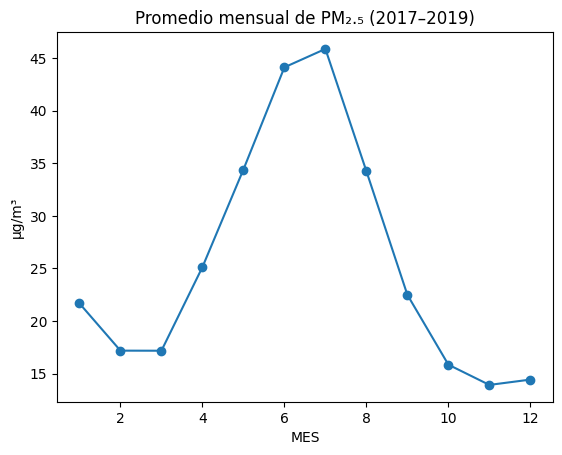

In [195]:
# Promedio mensual de PM2.5
df_contaminacion["MES"] = df_contaminacion["FECHA"].dt.month
df_contaminacion.groupby("MES")["PM25"].mean().plot(marker="o", title="Promedio mensual de PM₂.₅ (2017–2019)")
plt.ylabel("µg/m³")
plt.show()

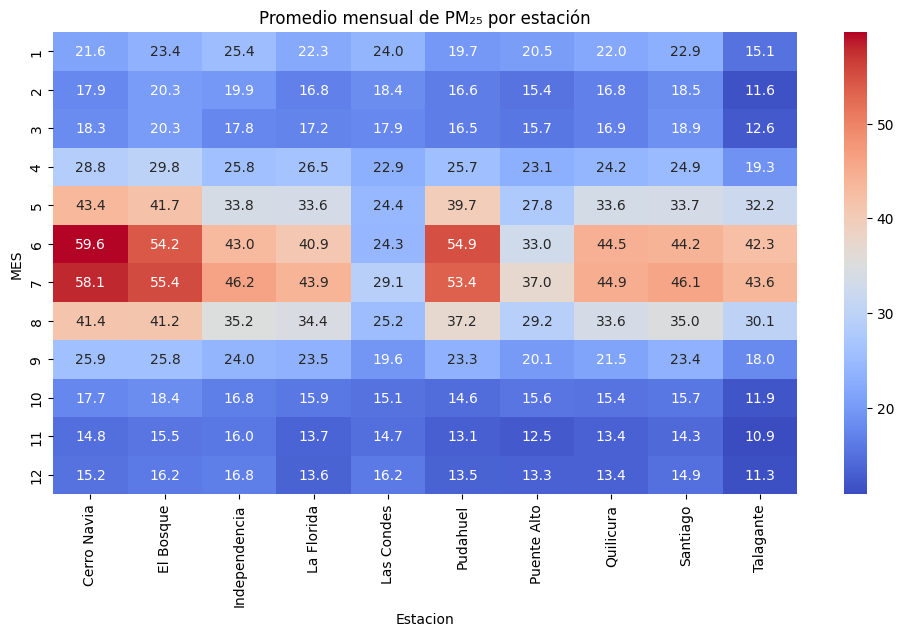

In [196]:
df_mes_estacion = df_contaminacion.groupby(["MES","Estacion"])["PM25"].mean().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(df_mes_estacion, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Promedio mensual de PM₂₅ por estación")
plt.show()

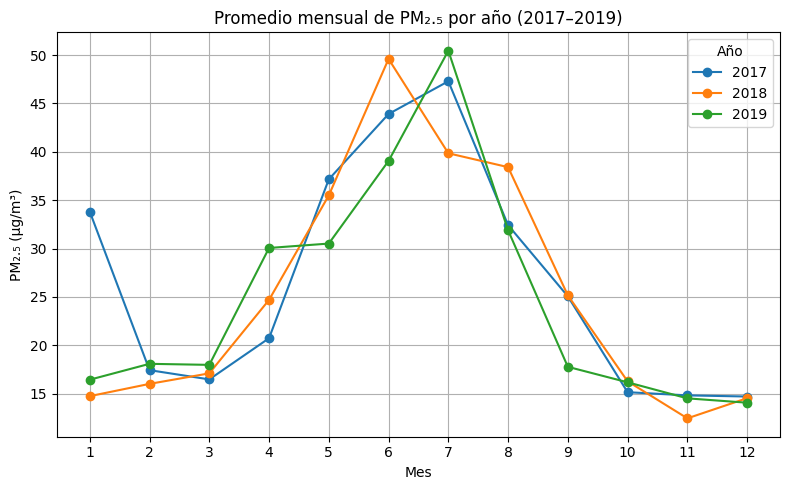

In [197]:
# Crear columnas de año y mes
df_contaminacion["AÑO"] = df_contaminacion["FECHA"].dt.year

# Agrupar por año y mes, y calcular el promedio de PM2.5
promedios = (
    df_contaminacion.groupby(["AÑO", "MES"])["PM25"]
    .mean()
    .reset_index()
)

# Crear la figura
plt.figure(figsize=(8,5))

# Graficar una línea por año
for año in sorted(df_contaminacion["AÑO"].unique()):
    data_año = promedios[promedios["AÑO"] == año]
    plt.plot(data_año["MES"], data_año["PM25"], marker="o", label=str(año))

# Personalizar
plt.title("Promedio mensual de PM₂.₅ por año (2017–2019)")
plt.xlabel("Mes")
plt.ylabel("PM₂.₅ (µg/m³)")
plt.xticks(range(1,13))
plt.legend(title="Año")
plt.grid(True)
plt.tight_layout()
plt.show()

## La distribución de pacientes por comuna en cada mes, en diferentes formatos:

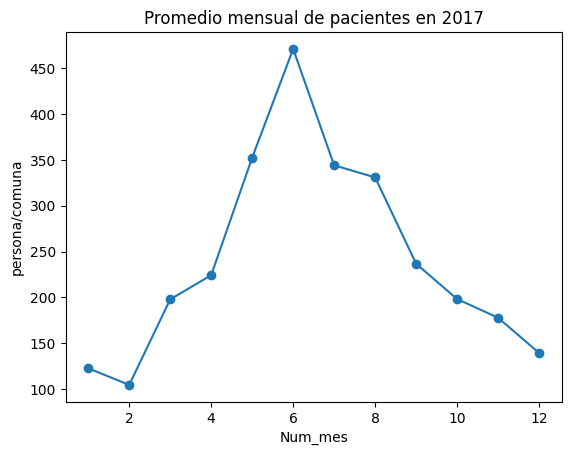

In [201]:
# Promedio mensual de pacientes por año
# clean_df_2017["MES"] = clean_df_2017["FECHA"].dt.month
df_REM17.groupby("Num_mes")["n_pacientes"].mean().plot(marker="o", title="Promedio mensual de pacientes en 2017")
plt.ylabel("persona/comuna")
plt.show()

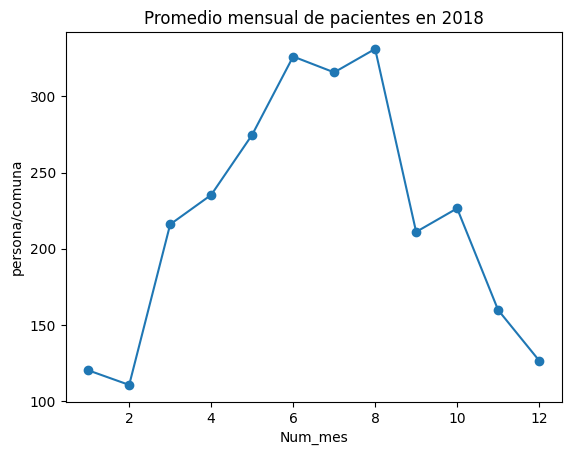

In [202]:
# Promedio mensual de pacientes por año
# clean_df_2017["MES"] = clean_df_2017["FECHA"].dt.month
df_REM18.groupby("Num_mes")["n_pacientes"].mean().plot(marker="o", title="Promedio mensual de pacientes en 2018")
plt.ylabel("persona/comuna")
plt.show()

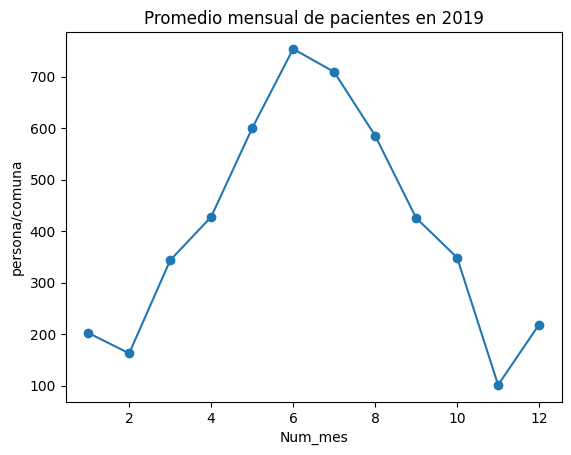

In [203]:
# Promedio mensual de pacientes por año
# clean_df_2017["MES"] = clean_df_2017["FECHA"].dt.month
df_REM19.groupby("Num_mes")["n_pacientes"].mean().plot(marker="o", title="Promedio mensual de pacientes en 2019")
plt.ylabel("persona/comuna")
plt.show()

Observamos que efectivamente el período en qué existen más pacientes de enfermedades respiratorias es en el periodo de Inveierno.

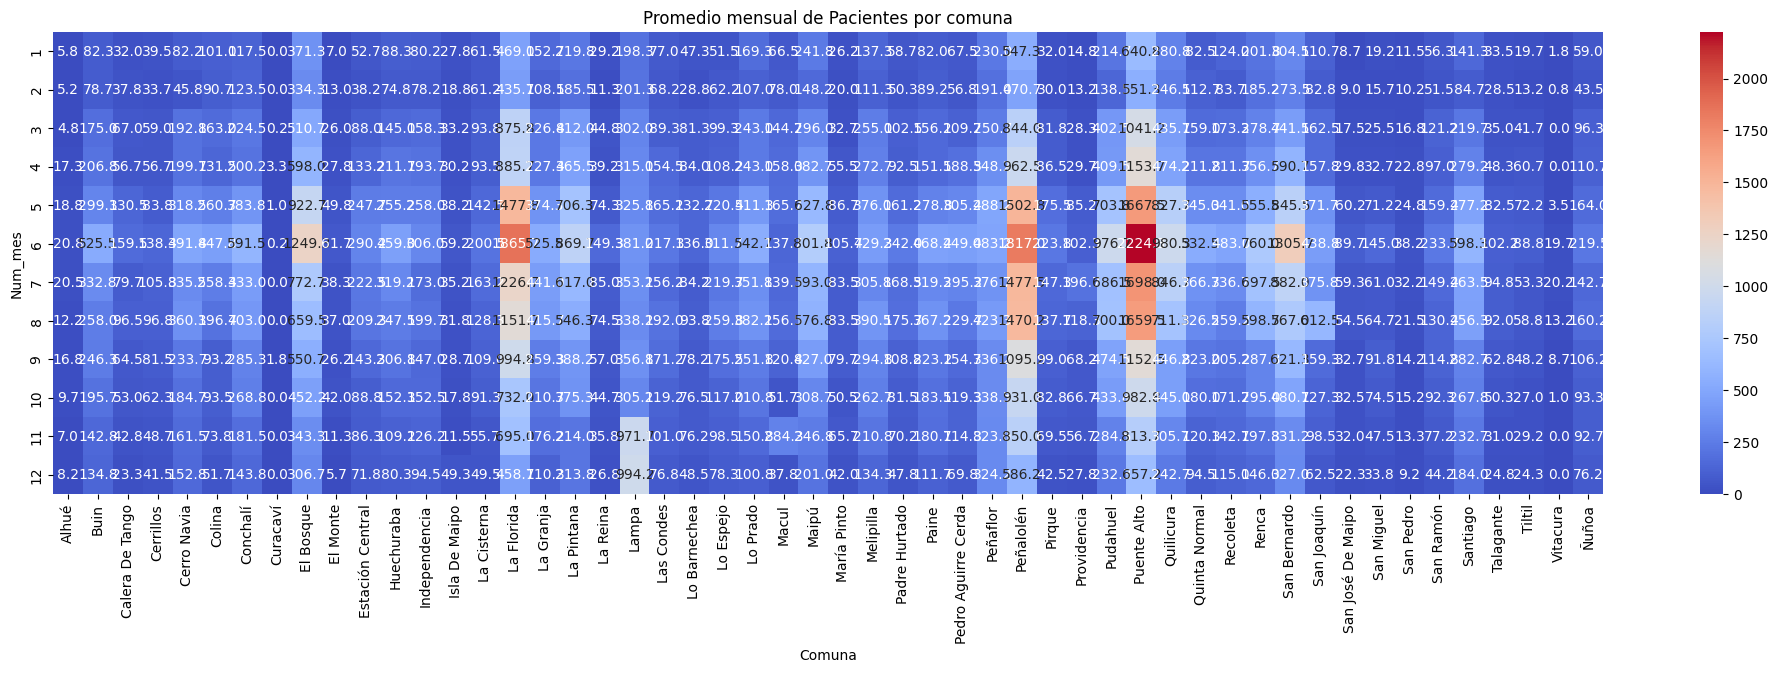

In [ ]:
df_pacientes_comuna_2017 = df_REM17.groupby(["Num_mes", "Comuna"])["n_pacientes"].mean().unstack()
plt.figure(figsize=(25,6))
sns.heatmap(df_pacientes_comuna_2017, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Promedio mensual de Pacientes por comuna en 2017")
plt.show()

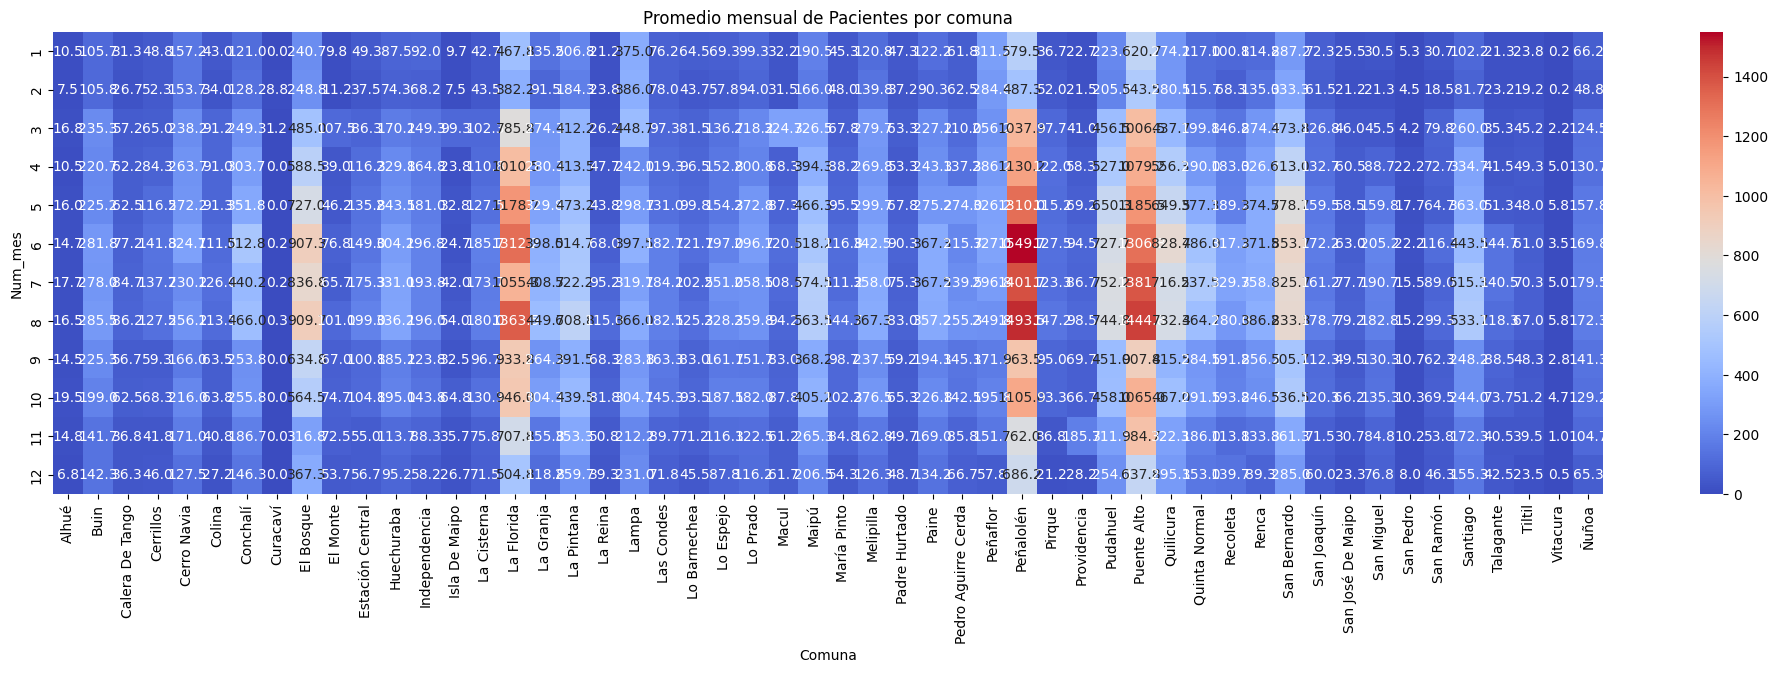

In [ ]:
df_pacientes_comuna_2018 = df_REM18.groupby(["Num_mes", "Comuna"])["n_pacientes"].mean().unstack()
plt.figure(figsize=(25,6))
sns.heatmap(df_pacientes_comuna_2018, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Promedio mensual de Pacientes por comuna en 2018")
plt.show()

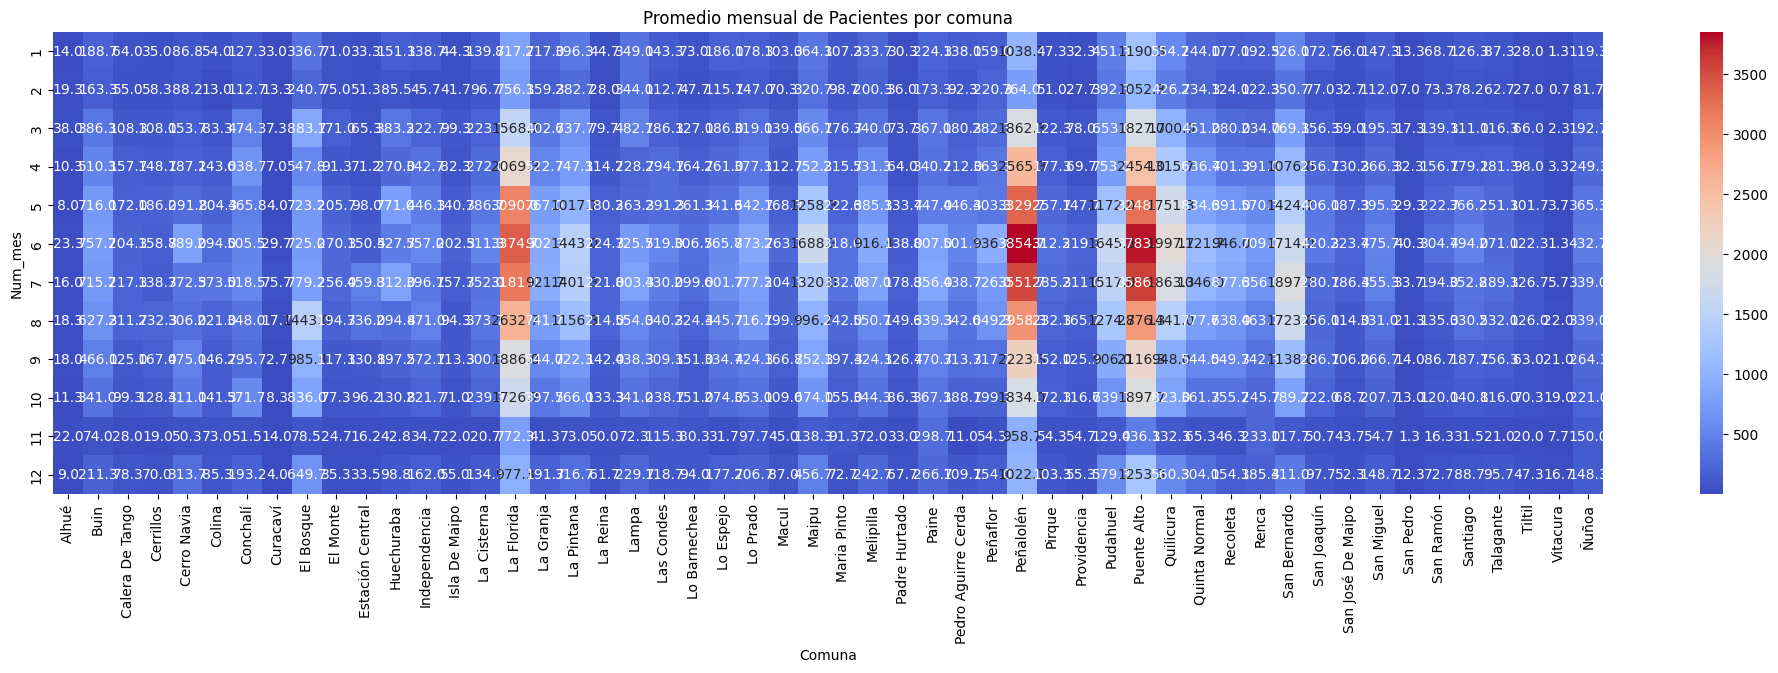

In [ ]:
df_pacientes_comuna_2019 = df_REM19.groupby(["Num_mes", "Comuna"])["n_pacientes"].mean().unstack()
plt.figure(figsize=(25,6))
sns.heatmap(df_pacientes_comuna_2019, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Promedio mensual de Pacientes por comuna en 2019")
plt.show()

# RELACION DE DATOS

Primero graficaremos la cantidad de paciente por comuna por año v/s indice promedio de contaminación por comuna por año.

In [257]:
def plotear_anual(año, df_rem_total, df_contam_total, comunas_gdf):
    """
    Genera una figura con dos mapas comparativos (Pacientes vs PM2.5) para un año dado.
    """
    # Filtrar datos para el año específico
    df_rem_año = df_rem_total[df_rem_total['Año'] == año]
    df_contam_año = df_contam_total[df_contam_total['Año'] == año] # Asumo que df_contam_total tiene columna 'Año'

    # Preparar datos de Pacientes
    promedio_pacientes = df_rem_año.groupby('Comuna')['n_pacientes'].mean().reset_index()
    mapa_pacientes = comunas_gdf.merge(promedio_pacientes, on='Comuna', how='left')

    # Preparar datos de Contaminación ---
    # Asumimos que df_contam_total ya tiene la columna 'Comuna' (renombrada de 'Estacion')
    promedio_pm25 = df_contam_año.groupby('Comuna')['PM25'].mean().reset_index()
    mapa_pm25 = comunas_gdf.merge(promedio_pm25, on='Comuna', how='left')

    # Configuración y Ploteo Lado a Lado
    fig, axes = plt.subplots(1, 2, figsize=(24, 10), sharex=True, sharey=True)
    ax1, ax2 = axes # Desempaquetar los ejes

    # Mapa de Pacientes (Izquierda)
    mapa_pacientes.plot(
        column='n_pacientes',
        ax=ax1,
        cmap='RdBu_r', # color cmap inverso del PM2.5 para mejor contraste 
        legend=True,
        edgecolor='black',
        linewidth=0.5,
        missing_kwds={"color": "lightgrey", "label": "Sin Datos"}
    )
    ax1.set_title(f'Promedio de Pacientes por Comuna ({año})', fontsize=16)
    ax1.set_axis_off()

    # Mapa de PM2.5 (Derecha)
    mapa_pm25.plot(
        column='PM25',
        ax=ax2,
        cmap='RdBu_r',
        legend=True,
        edgecolor='black',
        linewidth=0.5,
        missing_kwds={"color": "lightgrey", "label": "Sin Datos"}
    )
    ax2.set_title(f'Promedio de PM2.5 por Comuna ({año})', fontsize=16)
    ax2.set_axis_off()

    plt.suptitle(f'Comparativa Anual: Pacientes vs. Polución - Año {año}', fontsize=18, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para que el supertítulo no se corte
    plt.show()

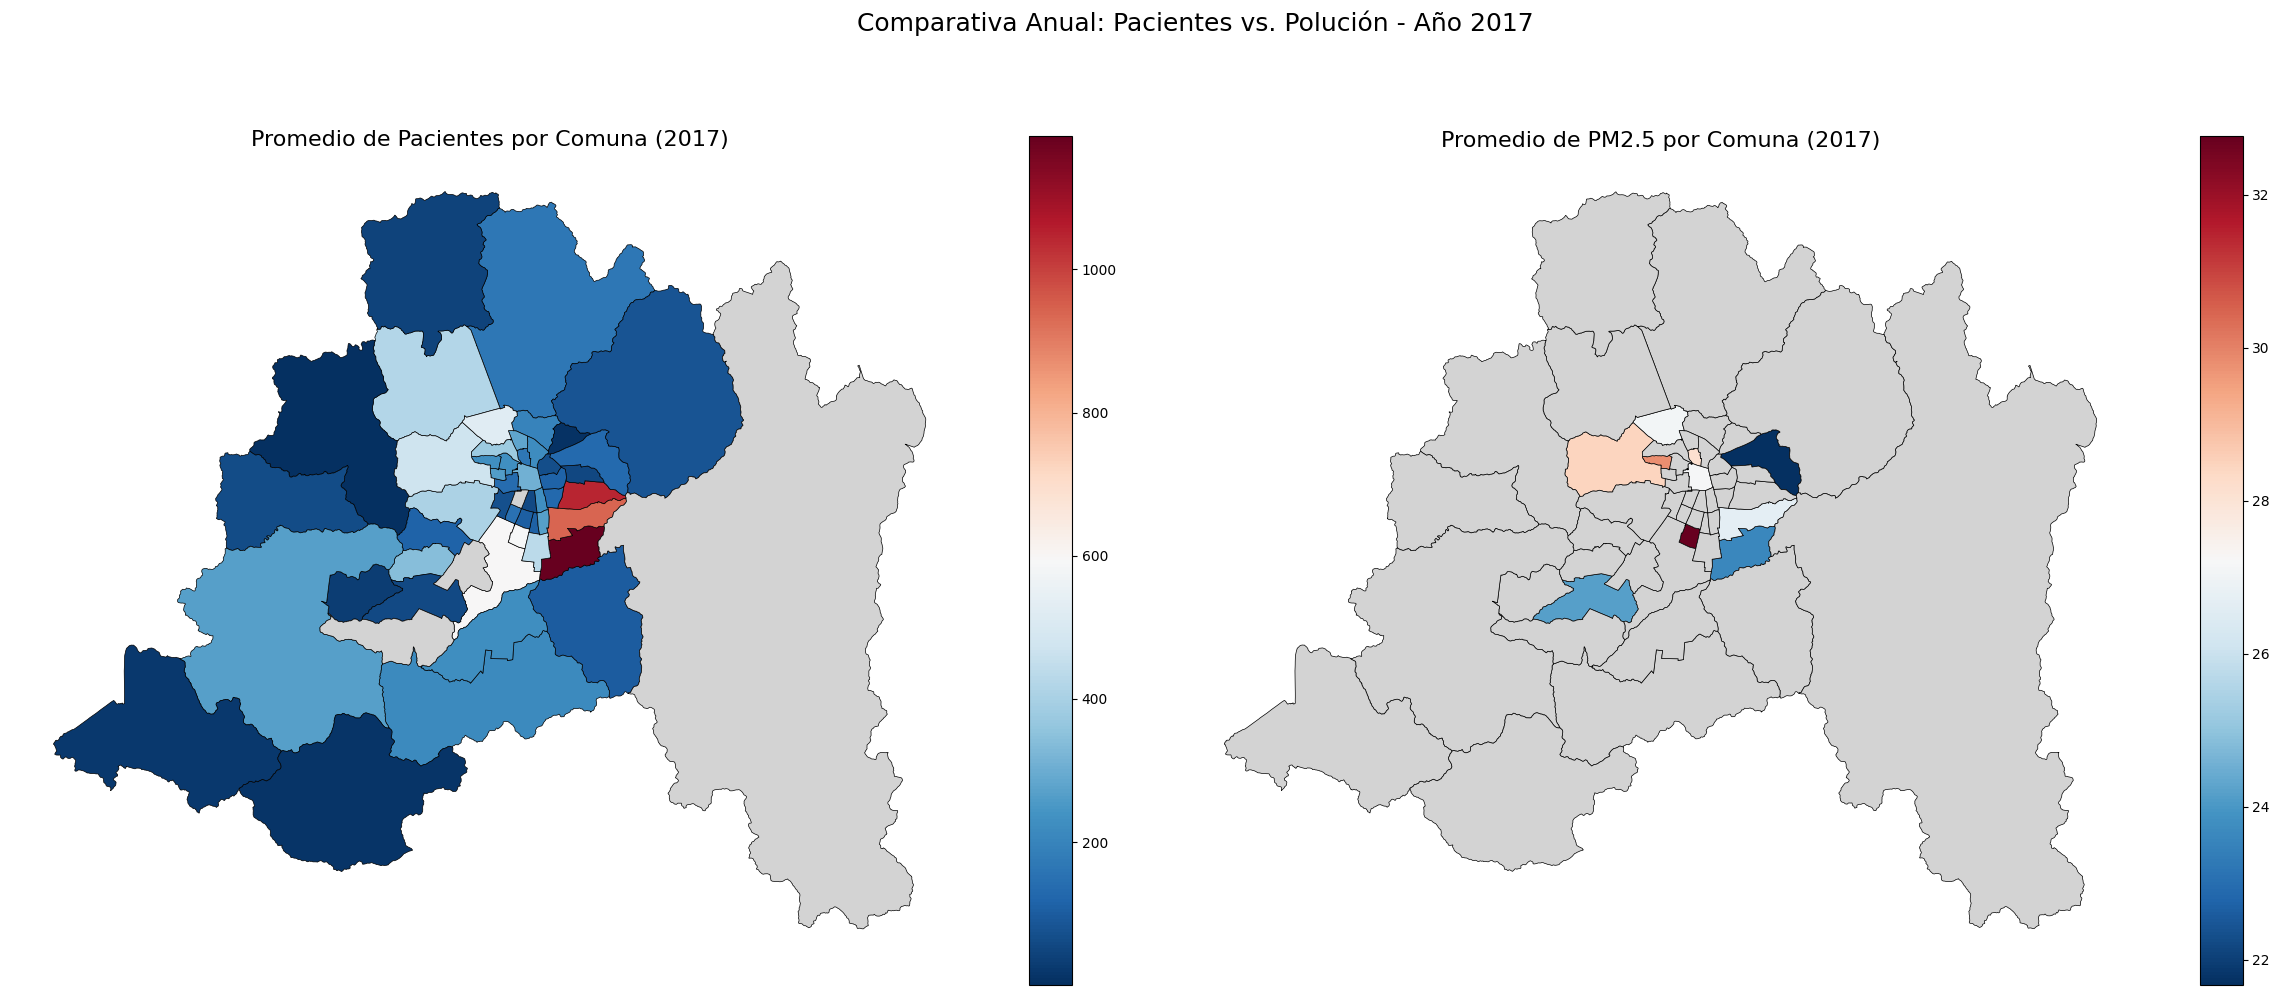

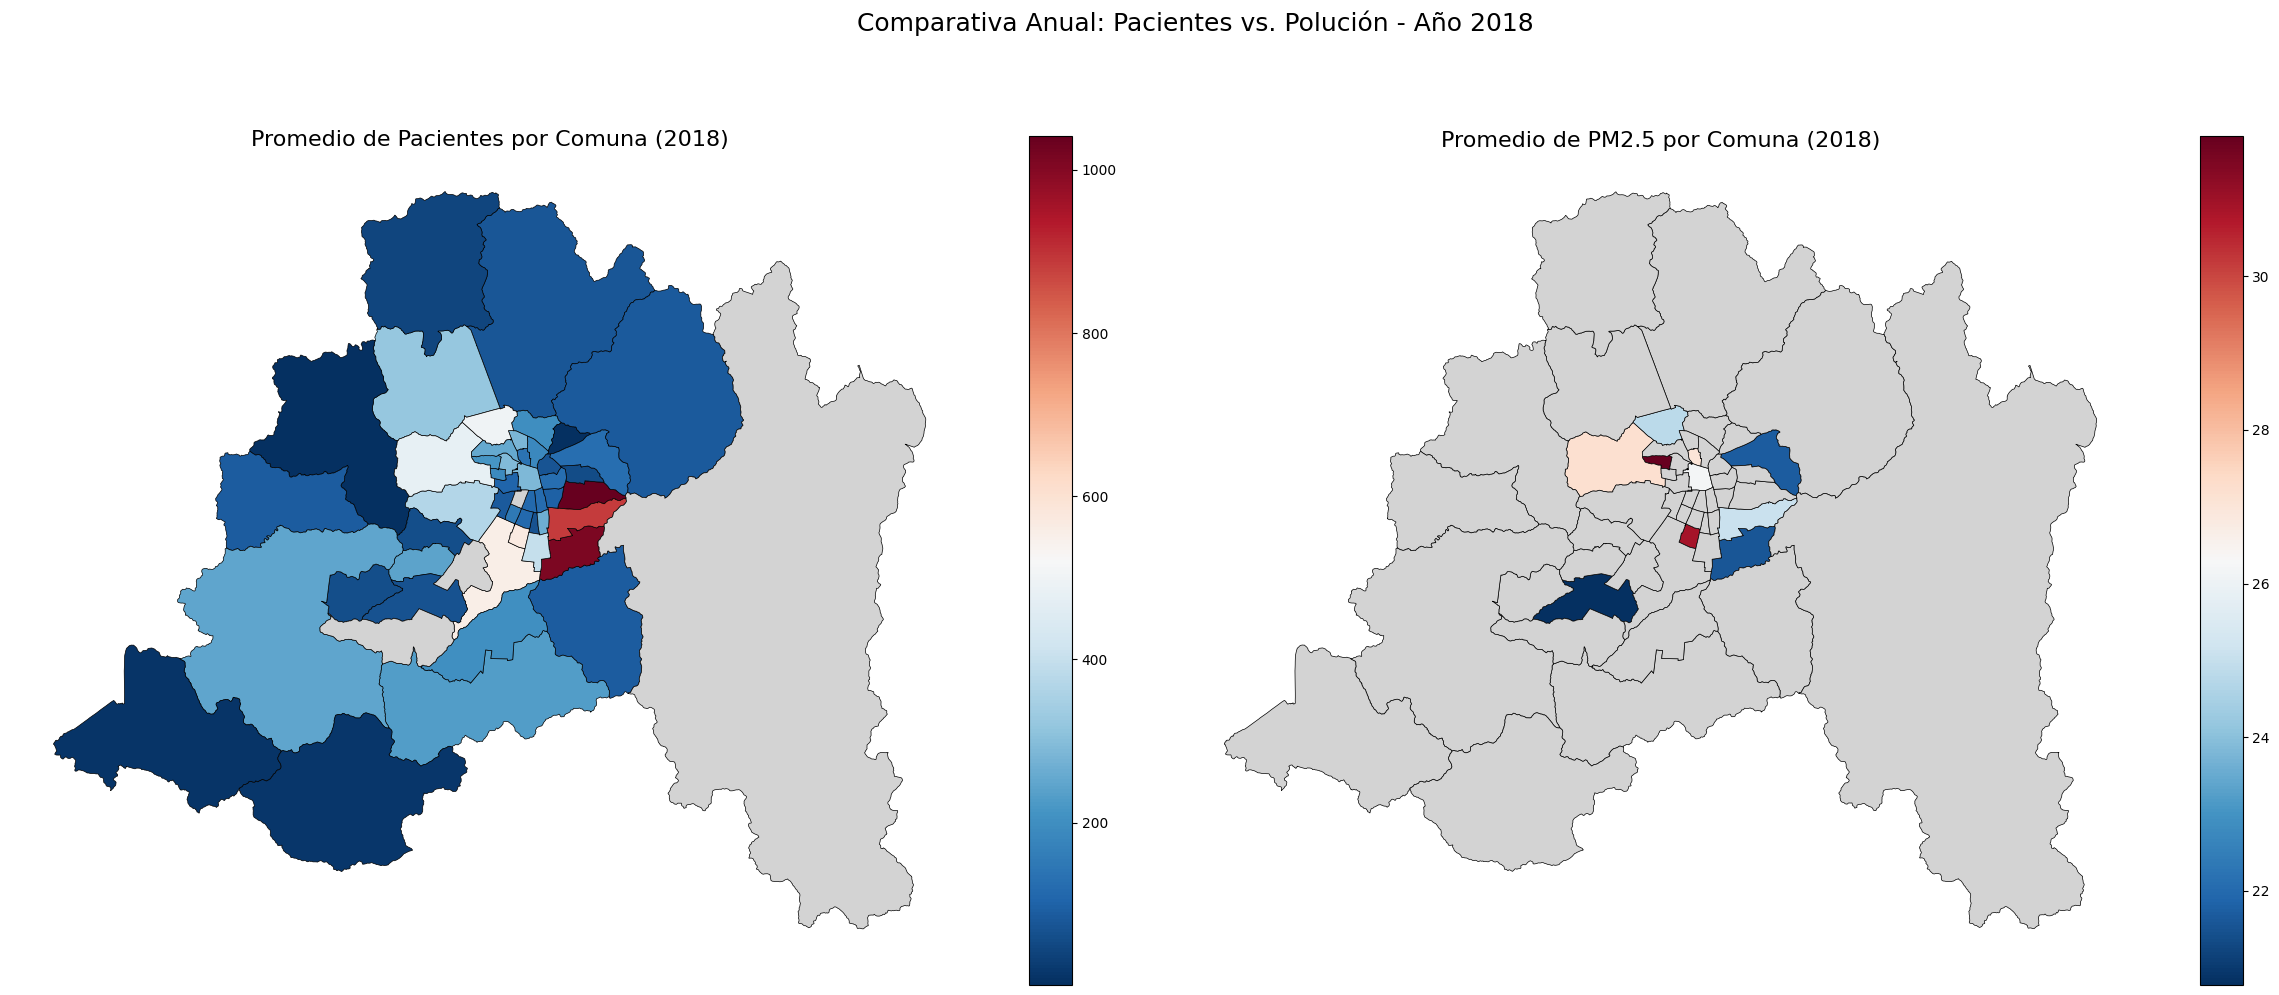

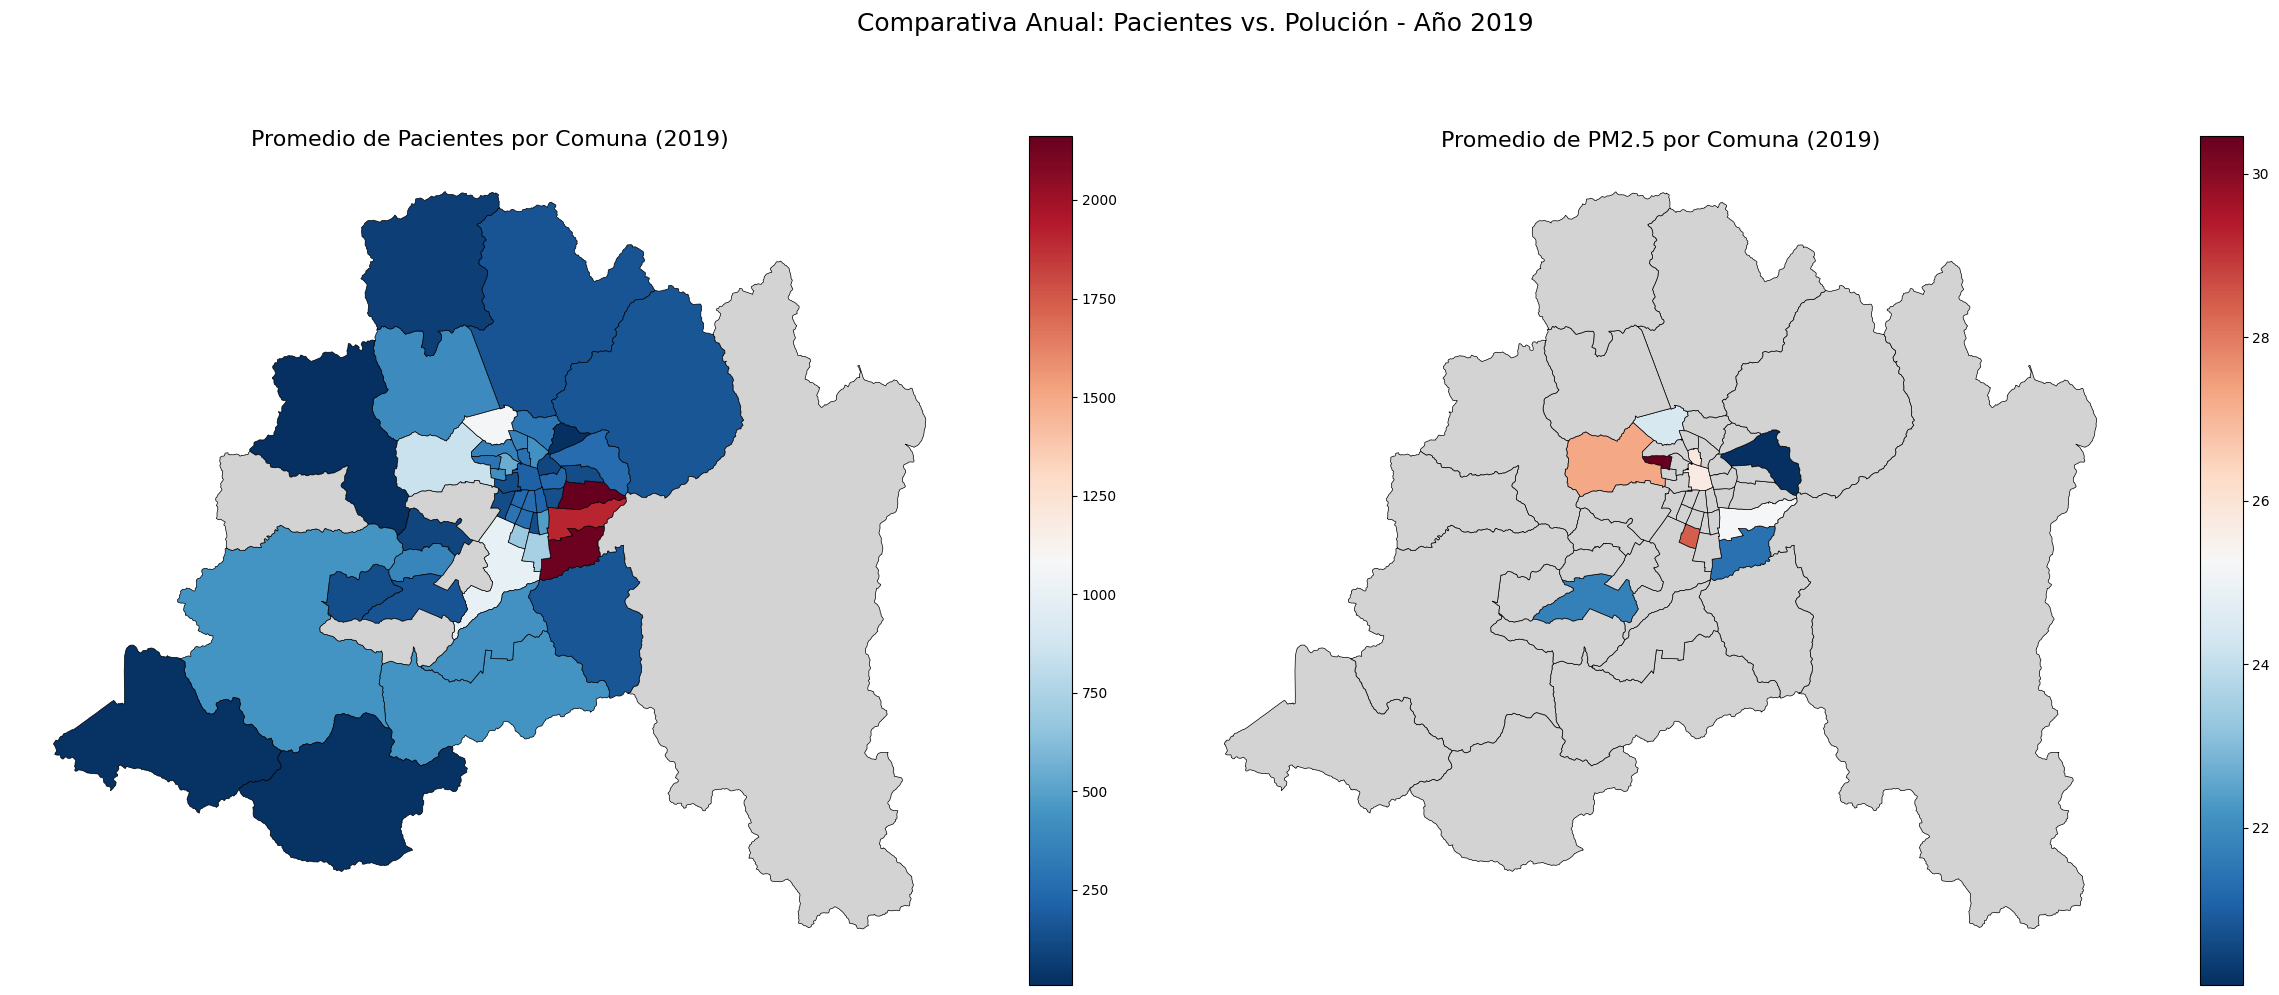

In [258]:
# renombrar columna Estacion a Comuna y AÑO a Año
df_contaminacion = df_contaminacion.rename(columns={'Estacion':'Comuna', 'AÑO': 'Año'})

plotear_anual(2017, df_REM17, df_contaminacion, comunas)
plotear_anual(2018, df_REM18, df_contaminacion, comunas)
plotear_anual(2019, df_REM19, df_contaminacion, comunas)

Ahora graficamos el promedio de paciente por comuna por año v/s indice promedio de contaminación por comuna.

In [246]:
df_REM = pd.concat([df_REM17, df_REM18, df_REM19], ignore_index=True)
# Calcular el promedio de pacientes global por cada comuna
promedio_pacientes_comuna = df_REM.groupby('Comuna')['n_pacientes'].mean().reset_index()

# Unir (Merge) los datos al GeoDataFrame usando la columna 'Comuna'
mapa_con_enfermos = comunas.merge(
    promedio_pacientes_comuna,
    on='Comuna',        # La columna que coincide en ambos DFs
    how='left'          # Mantenemos todas las comunas del mapa (left join)
)


PM25_por_comuna = df_contaminacion.groupby('Comuna')['PM25'].mean().reset_index()

# Unir (Merge) los datos al GeoDataFrame usando la columna 'Comuna'
mapa_con_PM25 = comunas.merge(
    PM25_por_comuna,
    on='Comuna',        # La columna que coincide en ambos DFs
    how='left'          # Mantenemos todas las comunas del mapa (left join)
)

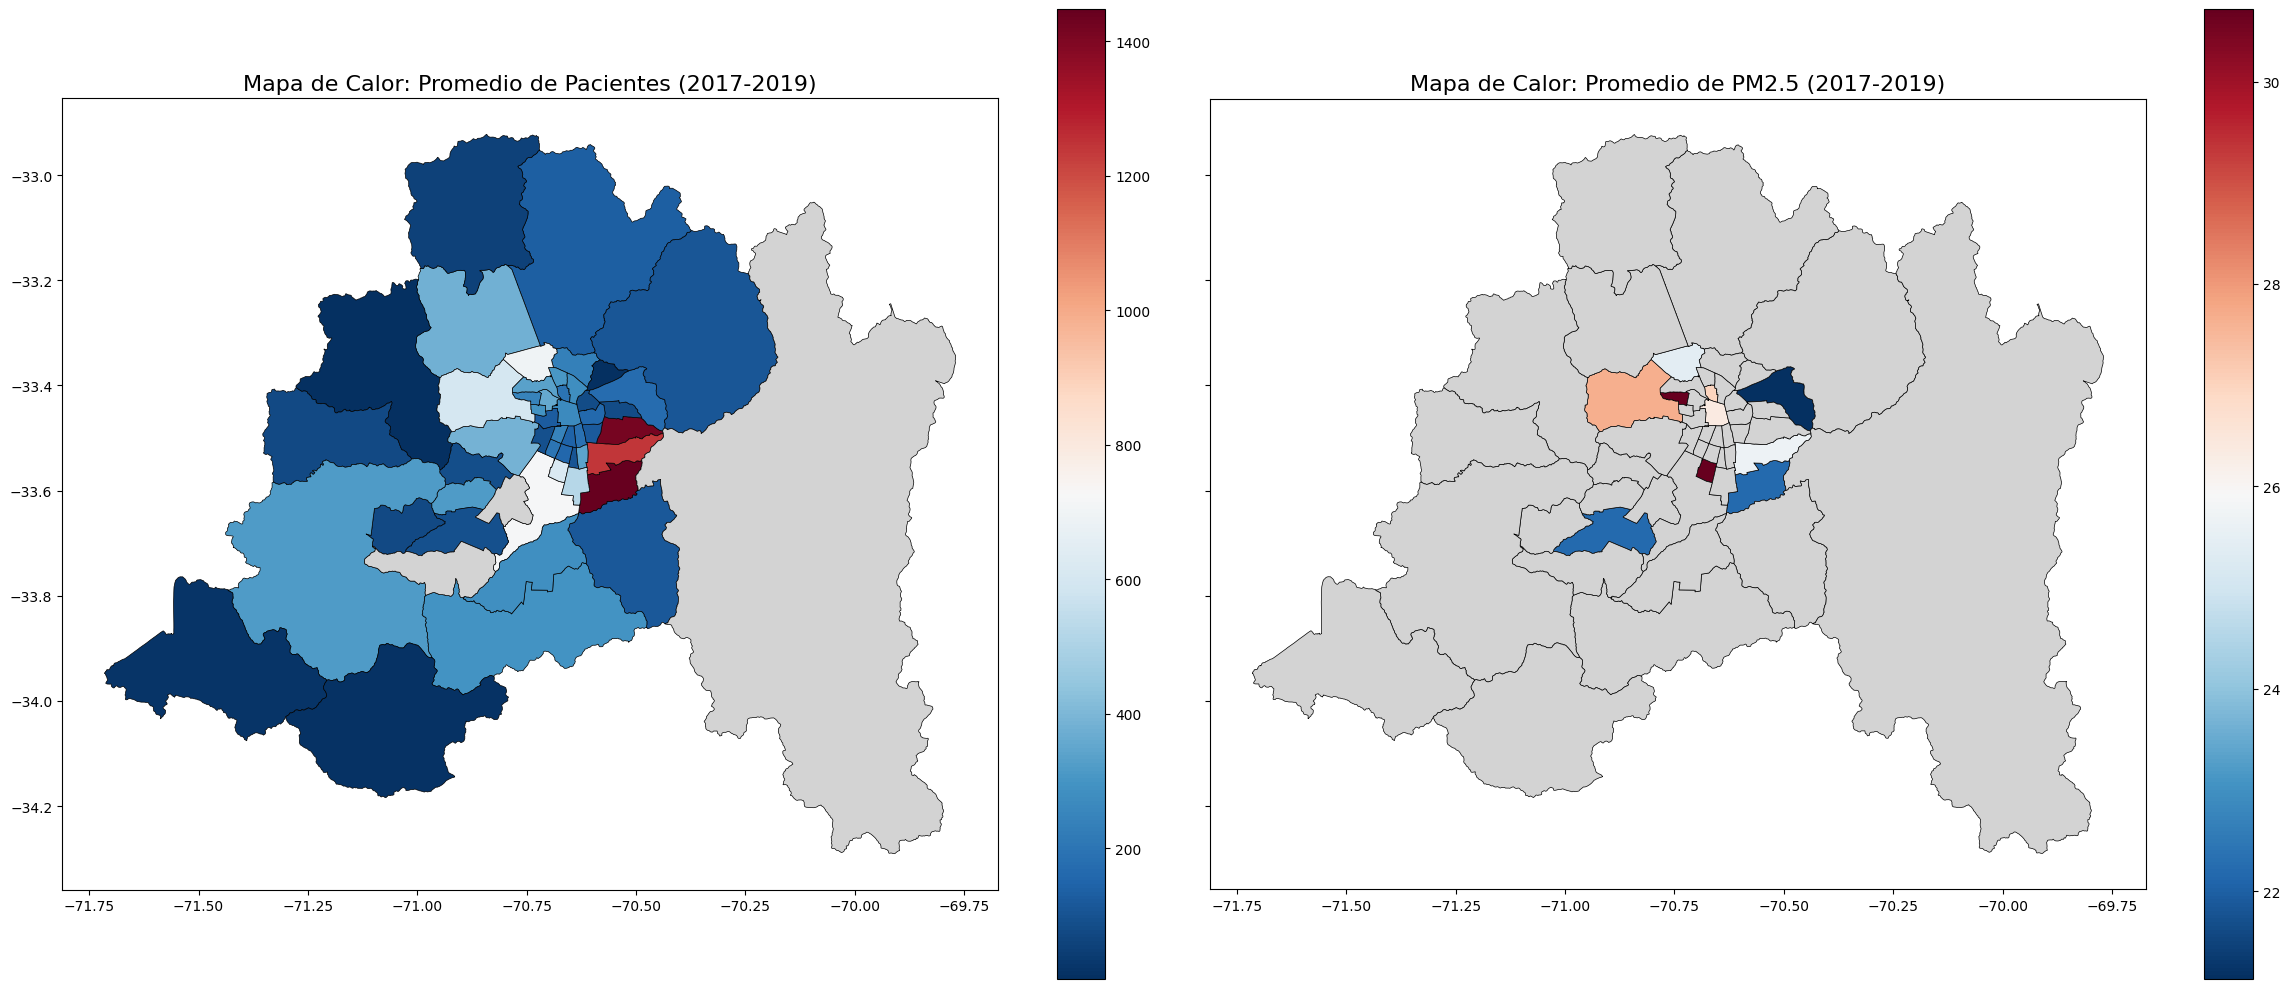

In [259]:
# sharey=True y sharex=True asegura que ambos mapas tengan la misma escala geográfica
fig, axes = plt.subplots(1, 2, figsize=(24, 10), sharex=True, sharey=True)

ax1 = axes[0] # Eje izquierdo
ax2 = axes[1] # Eje derecho

# Primer mapa: Pacientes en ax1
mapa_con_enfermos.plot(
    column='n_pacientes',
    ax=ax1,
    cmap='RdBu_r', # Colores cálidos
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={"color": "lightgrey", "label": "Sin Datos"}
)

ax1.set_title('Mapa de Calor: Promedio de Pacientes (2017-2019)', fontsize=16)
# ax1.set_axis_off()


# GSegundo mapa: PM2.5 en ax2
mapa_con_PM25.plot(
    column='PM25',
    ax=ax2,
    cmap='RdBu_r', # Colores cálidos
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={"color": "lightgrey", "label": "Sin Datos"}
)
ax2.set_title('Mapa de Calor: Promedio de PM2.5 (2017-2019)', fontsize=16)
# ax2.set_axis_off()

# Ajustar el diseño para que no se superpongan los elementos
plt.tight_layout()
plt.show()

In [260]:
# dataframe final con las columnas comuna, n_pacientes (promedio) y PM25 (promedio)
df_final = pd.merge(promedio_pacientes_comuna, PM25_por_comuna, on='Comuna', how='left')
# df_final.head()
# borrar comunas con nulos en PM25
df_final = df_final.dropna(subset=['PM25'])
# ordenar de mayor a menor n_pacientes
df_final = df_final.sort_values(by='n_pacientes', ascending=False).reset_index(drop=True)
df_final

,Comuna,n_pacientes,PM25
0,Puente Alto,1448.041667,22.195295
1,La Florida,1243.601852,25.671920
2,Quilicura,695.356481,25.403205
3,El Bosque,614.648148,30.717268
4,Pudahuel,598.092593,27.650708
5,Santiago,267.444444,26.349568
6,Cerro Navia,246.134259,30.701520
7,Independencia,192.638889,26.979252
8,Las Condes,172.467593,21.131355
9,Talagante,94.097222,22.185104


In [261]:
df_final.describe()

,n_pacientes,PM25
count,10.000000,10.000000
mean,557.252315,25.898519
std,467.251330,3.354212
min,94.097222,21.131355
25%,206.012731,22.997272
50%,432.768519,26.010744
75%,675.179398,27.482844
max,1448.041667,30.717268
